## Crowd Counting Model

In [1]:
# Set up the environment
!pip install torchvision
#!pip install cython # apt install in terminal
!pip install h5py
!pip install google
!pip install google-api-core
!pip install colab

In [2]:
# Import the packages
%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

/app/CSRNet-pytorch


In [3]:
%%time
import os
# Download the architecture
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -U scipy torch_snippets torch_summary
    !git clone https://github.com/sizhky/CSRNet-pytorch.git
    

Requirement already up-to-date: scipy in /usr/local/lib/python3.8/dist-packages (1.10.1)
Requirement already up-to-date: torch_snippets in /usr/local/lib/python3.8/dist-packages (0.524)
Requirement already up-to-date: torch_summary in /usr/local/lib/python3.8/dist-packages (1.4.5)
Cloning into 'CSRNet-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), 623.72 KiB | 1.44 MiB/s, done.
CPU times: user 38.3 ms, sys: 25.5 ms, total: 63.8 ms
Wall time: 3.74 s


In [4]:
# Unzip the dataset
print('unzipping data...')
!unzip -qq shanghaitech.zip

unzipping data...

unzip:  cannot find or open shanghaitech.zip, shanghaitech.zip.zip or shanghaitech.zip.ZIP.


In [5]:
# Provide the location of the images, ground truth and heatmap folders
part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

In [6]:
# Define the training and validation datasets and dataloaders
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [7]:
!pip install python-utils

In [9]:
# Define the network architecture
import torch.nn as nn
import torch
from torchvision import models
import sys
#sys.path.insert(0, '/app/CSRNet-pytorch/')
import utils 
from utils import save_net,load_net



def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [10]:
# Define the CSRNet network architec
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [11]:
# Define the functions to train and validate on a batch of data.
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [12]:
# Train the model over increasing epochs
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  val_pts_loss: 414.745  val_loss: 0.057  trn_pts_loss: 415.094  trn_loss: 0.048  (43.28s - 822.29s remaining)
EPOCH: 2.000  val_pts_loss: 335.720  val_loss: 0.050  trn_pts_loss: 282.662  trn_loss: 0.040  (83.76s - 753.82s remaining)
EPOCH: 3.000  val_pts_loss: 213.091  val_loss: 0.043  trn_pts_loss: 210.276  trn_loss: 0.036  (124.41s - 705.00s remaining)
EPOCH: 4.000  val_pts_loss: 161.006  val_loss: 0.042  trn_pts_loss: 165.753  trn_loss: 0.033  (165.06s - 660.25s remaining)
EPOCH: 5.000  val_pts_loss: 147.614  val_loss: 0.041  trn_pts_loss: 149.124  trn_loss: 0.032  (205.73s - 617.19s remaining)
EPOCH: 6.000  val_pts_loss: 187.365  val_loss: 0.040  trn_pts_loss: 145.506  trn_loss: 0.031  (246.39s - 574.90s remaining)
EPOCH: 7.000  val_pts_loss: 123.916  val_loss: 0.038  trn_pts_loss: 146.487  trn_loss: 0.031  (287.04s - 533.08s remaining)
EPOCH: 8.000  val_pts_loss: 129.504  val_loss: 0.038  trn_pts_loss: 137.223  trn_loss: 0.030  (327.71s - 491.56s remaining)
EPOCH: 9.0

### Inference

In [13]:
# Get a test image and normalize it.
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)
img = transform(Image.open(f).convert('RGB')).to(device)

shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_40.jpg

Predicted Count :  226

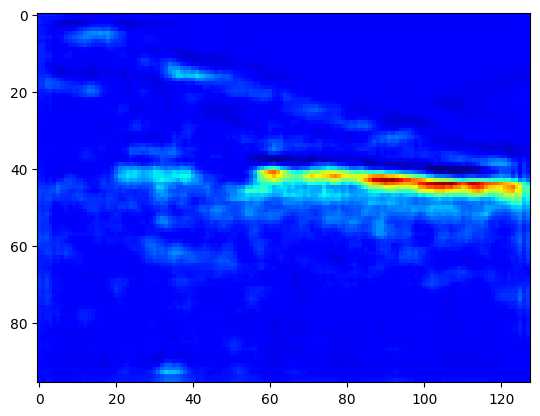

In [14]:
# Pass the image through the trained model.
output = model(img[None])
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()